In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-18

Goals: 
Fit the data

Each Section can/should run independently,
only these initial imports should be shared among all sections

Open questions:
None at the moment
"""

import os

import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import socket

machine_name = socket.gethostname()

print("Machine Name:", machine_name)

Machine Name: baldur.astro.washington.edu


In [2]:
import dask

if machine_name == "epyc.astro.washington.edu":
    dask.config.set({"temporary-directory": '/epyc/ssd/users/ncaplar/tmp'})
elif machine_name == "baldur.astro.washington.edu":
    dask.config.set({"temporary-directory": '/local/tmp'})
else:
    # Handle other machines or set a default directory
    dask.config.set({"temporary-directory": '/default/tmp'})


# one worker
# dask.config.set(scheduler='threads') 
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=1, n_workers=8, memory_limit='40GiB', processes=True)
# cluster = LocalCluster()
client = Client(cluster)
#cluster.adapt(minimum=10, maximum=40) 

In [3]:
# Setup base directory for saving output files
username= "ncaplar"
basedir = f"/astro/users/{username}/data/"

In [4]:
dask.config.get("temporary-directory")

'/local/tmp'

In [5]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 320.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32888,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 320.00 GiB
Comm: tcp://127.0.0.1:45415,Total threads: 1
Dashboard: http://127.0.0.1:44754/status,Memory: 40.00 GiB
Nanny: tcp://127.0.0.1:38586,


# Tape Single Pixel - real data 

## loading and inspection of the data

In [ ]:
# if running on baldur or epyc
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
                 )

/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1116: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1116: UserWarning: Divisions for source are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(


Filter data

In [ ]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1577: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")


In [ ]:
ens._object.compute()

AttributeError: 'NoneType' object has no attribute 'compute'

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

(17.0, 21.0)

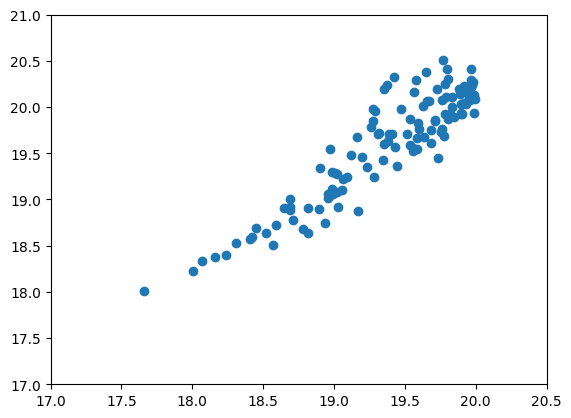

In [ ]:
plt.scatter(ens._object['rMeanPSFMag_ps1_otmo'].compute().values, ens._object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

(17.0, 23.0)

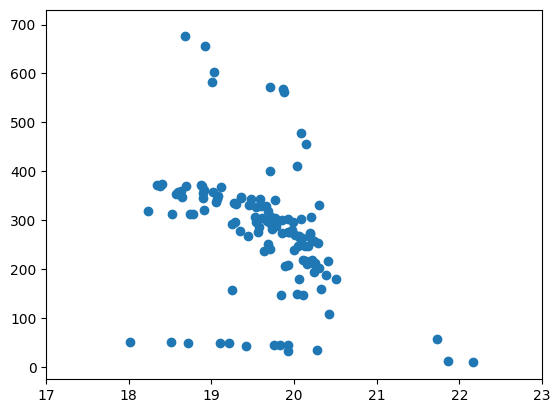

In [ ]:
ens_nobs = ens.calc_nobs(temporary=False)

plt.scatter( ens._object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs._object['nobs_total'].compute().values)
plt.xlim(17,23)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

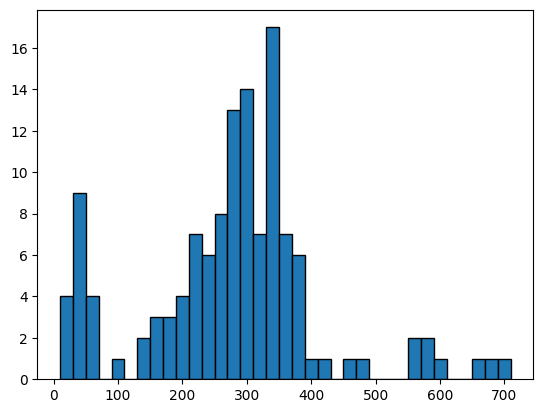

In [ ]:

data = ens_nobs._object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges

## Computation

In [ ]:
# 9min, 13 sec on baldur, for 603 sources in 4 partitions
# 7min, 30 sec on baldur, for 603 sources in 4 partitions, Nov 7
# 5min, 14 sec on baldur, for 603 sources in 10 partitions, Nov 7
# 2min, 50 sec on baldur, for 127 sources in 4 partitions
# 5min, 3 sec on epyc, for 127 sources in 4 partitions
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/tape/ensemble.py:1556: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

In [ ]:
def pack_output_to_parquet(result, cols, output_dir, output_filename, drop_cols=[], full=False):
    """Packs output to a dataframe, written as a parquet file. The created dataframe object is returned for inspection."""
    result_df = None
    if full:
        # Construct dataframes with the results for each object.
        dfs = []
        for i in range(len(result)):
            obj_data = result.iloc[i]
            # Construct a series representing the index
            obj_index = pd.Series(np.full(len(obj_data), result.index[i]), name=result.index.name)
            dfs.append(pd.DataFrame(data=obj_data, columns=cols, index=obj_index))

        # Concatenate all of the per-object dataframes
        result_df = pd.concat(dfs)
    else:
        # Each object only has a 1D array in the result series, so the constructed
        # dataframe has the same number of rows. So we can just do a 1:1 mapping with column names 
        result_df = pd.DataFrame(columns=cols, index=result.index)
        for i in range(len(result)):
            result_df.iloc[i] = result[i]

    # Drop any columns if requested.
    if drop_cols:
        result_df = result_df.drop(columns=drop_cols)

    # Write the output to the parquet file
    pa_table = pa.Table.from_pandas(result_df)
    pa_table
    pa.parquet.write_table(pa_table, f"{output_dir}/data/{output_filename}.parquet")
    return result_df

# Create columns for result of using just the drw kernel
param_cols = ['log_drw_scale', 'log_drw_amp']
init_param_cols = ["init_" + c for c in param_cols]
drw_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols

# Create columns for result of combining the drw params with periodic params
param_cols = ['log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp']
init_param_cols = ["init_" + c for c in param_cols]
combined_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols


In [ ]:
# Save output for results from just the drw kernel
drw_df = pack_output_to_parquet(res_tsp_drw, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw")
drw_df

/tmp/ipykernel_61320/2460734338.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_df.iloc[i] = result[i]


,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
SDSS_NAME_dr16q_constant,,,,,,
024050.36-003109.0,40.08991,40.08991,2.980099,-0.760837,3.534287,0.225864
024052.82-004110.9,-34.805998,-34.805998,-3.807629,-4.933484,0.979914,0.808098
024126.71-004526.3,-28.434609,-28.434609,2.066565,-1.24888,1.872701,-2.842854
024151.76-001953.6,35.285865,35.285865,2.441909,-1.277017,3.854836,-1.304851
024154.42-004757.6,-12.792811,-12.792811,1.545028,-4.170314,1.554912,-1.710292
...,...,...,...,...,...,...
024419.10+005539.2,-94.10112,-94.10112,2.633371,-0.931073,2.623782,-2.06715
024448.90+002858.6,-72.338187,-72.338187,2.415671,-0.888955,3.037724,-0.912945
024504.47+002841.3,13.080527,13.080527,2.468771,-0.839532,1.792329,1.68365


In [ ]:
# Save output for results from the combined drw and periodic kernel
combined_df = pack_output_to_parquet(res_tsp, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0")
combined_df

/tmp/ipykernel_61320/2460734338.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_df.iloc[i] = result[i]


,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
SDSS_NAME_dr16q_constant,,,,,,,,,,
024050.36-003109.0,39.083982,39.083982,3.0885,-0.715306,1.468924,-1.164669,1.460723,-1.409983,0.468374,-1.184457
024052.82-004110.9,-35.156772,-35.156772,-12.49335,-10.902907,2.738975,-1.331822,0.232252,-0.446263,3.155693,-2.31874
024126.71-004526.3,-29.632743,-29.632743,-10.076967,-6.401982,2.944183,-1.101969,0.780093,1.537832,3.032145,-1.003249
024151.76-001953.6,31.643813,31.643813,2.550391,-1.240236,1.469939,-1.185938,4.436064,-0.351747,1.432706,-0.935809
024154.42-004757.6,-12.792812,-12.792812,3.320252,-1.58099,-0.159079,-2.115329,2.137705,1.485551,1.079105,-1.820266
...,...,...,...,...,...,...,...,...,...,...
024419.10+005539.2,-97.450038,-97.450038,2.66236,-1.459577,2.504225,-1.096036,3.645036,-2.128168,2.507581,-2.122817
024448.90+002858.6,-75.779812,-75.779812,2.488547,-1.149155,2.834314,-0.926675,4.609371,-1.789724,2.784006,-1.233347
024504.47+002841.3,12.178009,12.178009,2.478015,-1.004705,3.046591,-0.992085,1.792329,1.68365,3.509834,-0.760212


# Redo but save all results (full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
# Save output for results from just the drw kernel
drw_df_full = pack_output_to_parquet(res_tsp_drw_full, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw_full", full=True)
drw_df_full

In [ ]:
# Save output for results from the combined drw and periodic kernel
combined_df_full = pack_output_to_parquet(res_tsp_full, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_full", full=True)
combined_df_full

# Alerce alerts

In [ ]:
datapath = "/astro/store/epyc3/data3/alerce_alerts/parquet/"

names = []
for i in range(12,36):
    name = datapath+f"source/lcs_00{i}.parquet"
    names.append(name)

# Ensemble already initialized in the start
# ens = Ensemble()

colmap = ColumnMapper(id_col="oid",
                      time_col="mjd",
                      flux_col="magpsf_corr",
                      err_col="sigmapsf_corr_ext",
                      band_col="fid")
ens.from_parquet(source_file=names,
                #source_file=datapath+"source/lcs_000*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sort= False)

ens.dropna()
ens.query("fid == 1", table="source").prune(30)

ens.calc_nobs()
ens._sync_tables()

/data/epyc/users/ncaplar/github/tape/src/tape/ensemble.py:1116: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/data/epyc/users/ncaplar/github/tape/src/tape/ensemble.py:1116: UserWarning: Divisions for source are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/data/epyc/users/ncaplar/github/tape/src/tape/ensemble.py:1577: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")


In [ ]:
# to see where the divisions are
divisions = ens._source.divisions
divisions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [ ]:
# Define a function to compute the number of rows in a partition
def count_rows(partition):
    return len(partition)

# Use the map function to apply the count_rows function to each partition
n_sources_per_div = ens._source.map_partitions(count_rows, meta=int).compute()

print("Number of rows in each partition:", n_sources_per_div)

Number of rows in each partition: 0     86552
1     89988
2     90614
3     82138
4     88354
5     87989
6     88816
7     85601
8     88069
9     83776
10    81095
11    89587
12    85507
13    82784
14    84456
15    83327
16    85690
17    85462
18    85831
19    87940
20    86472
21    91392
22    85188
23    84192
dtype: int64


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [ ]:
# our ensamble is highly inhomogenous, so we need to repartition it
# Repartition the Dask DataFrame
# ens._source = ens._source.repartition(npartitions=32, force=True)

In [ ]:
ens._source = ens._source.shuffle(on="oid", npartitions=8, compute=True)
ens._source.persist()

In [ ]:
divisions = ens._source.divisions
divisions

(None, None, None, None, None, None, None, None, None)

In [ ]:
# Let us try the same thing again
n_sources_per_div = ens._source.map_partitions(count_rows, meta=int).compute()

print("Number of rows in each partition:", n_sources_per_div)

/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


Number of rows in each partition: 0     63626
1     64805
2     65539
3     65759
4     67373
5     61910
6     65393
7     62680
8     62398
9     62097
10    65615
11    68116
12    64807
13    65594
14    68252
15    63392
16    64445
17    66352
18    66959
19    67756
20    64957
21    63420
22    65976
23    66582
24    65932
25    65824
26    63021
27    64007
28    65482
29    62297
30    64185
31    67481
dtype: int64


In [ ]:
ens.check_lightcurve_cohesion()

True

In [ ]:
# how many objects
print(len(ens._object))


31892


unique_lengths: 336


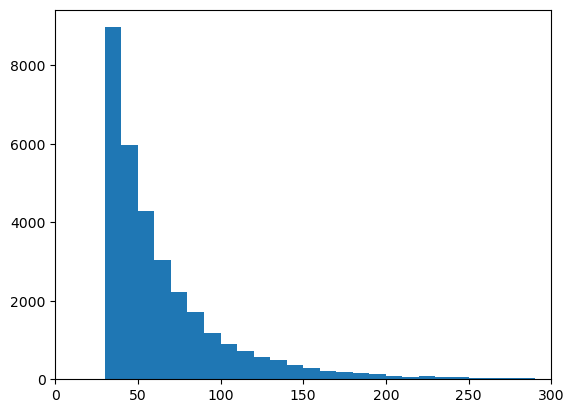

In [ ]:
nobs_data = ens._object["nobs_total"].values.compute()
binwidth=10
plt.hist(nobs_data, bins=np.arange(min(nobs_data), max(nobs_data) + binwidth, binwidth))
plt.xlim(0,300)

print(f"unique_lengths: {len(np.unique(nobs_data))}")

In [ ]:
# 8 workers (15 min if we move to 8 partitions)
# 8 workers 17 min if no shuffle
# 8 workers , 19 minutes if we move to 32 partitions
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd', "magpsf_corr", "sigmapsf_corr",
                compute=True, meta=None, n_init=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
res_tsp_drw[22]

/tmp/ipykernel_97485/2371604810.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res_tsp_drw[22]


Array([ 1.62910729e+02,  1.62910729e+02,  1.40229393e+01, -1.21802209e-01,
        4.60937118e+00, -1.78972364e+00], dtype=float64)

# ZTF - first load

In [ ]:
rel_path = "/data3/epyc/data3/hipscat/catalogs/ztf_dr14_x_agns_source"

from pyarrow import parquet
# parquet.read_schema(f"{rel_path}/Norder=8/Dir=210000/Npix=217286.parquet", memory_map=True)

parquet.read_schema("/epyc/projects3/sean_hipscat/agns_x_ztf_source/Norder=8/Dir=210000/Npix=217286.parquet", memory_map=True)


SDSS_NAME_dr16q_constant: binary
PLATE_dr16q_constant: int64
MJD_dr16q_constant: int64
FIBERID_dr16q_constant: int64
RA_dr16q_constant: double
DEC_dr16q_constant: double
OBJID_dr16q_constant: binary
IF_BOSS_SDSS_dr16q_constant: binary
Z_DR16Q_dr16q_constant: double
SOURCE_Z_DR16Q_dr16q_constant: binary
Z_FIT_dr16q_constant: double
Z_SYS_dr16q_constant: double
Z_SYS_ERR_dr16q_constant: double
EBV_dr16q_constant: double
SN_MEDIAN_ALL_dr16q_constant: double
FEII_UV_EW_dr16q_constant: double
FEII_UV_EW_ERR_dr16q_constant: double
FEII_OPT_EW_dr16q_constant: double
FEII_OPT_EW_ERR_dr16q_constant: double
LOGL1350_dr16q_constant: double
LOGL1350_ERR_dr16q_constant: double
LOGL1700_dr16q_constant: double
LOGL1700_ERR_dr16q_constant: double
LOGL2500_dr16q_constant: double
LOGL2500_ERR_dr16q_constant: double
LOGL3000_dr16q_constant: double
LOGL3000_ERR_dr16q_constant: double
LOGL5100_dr16q_constant: double
LOGL5100_ERR_dr16q_constant: double
LOGLBOL_dr16q_constant: double
LOGLBOL_ERR_dr16q_consta

In [ ]:
"""
colmap = ColumnMapper(id_col="_hipscat_index",
                      time_col="mjd_ztf_source",
                      flux_col="mag_ztf_source",
                      err_col="magerr_ztf_source",
                      band_col="band_ztf_source")
ens.from_parquet(source_file="/epyc/projects3/sean_hipscat/agns_x_ztf_source/Norder*/Dir*/Npix*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 partition_size="100MB")
ens._source.reset_index().set_index("_hipscat_index").to_parquet("/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar/")

"""


colmap = ColumnMapper(id_col="_hipscat_index",
                      time_col="mjd_ztf_source",
                      flux_col="mag_ztf_source",
                      err_col="magerr_ztf_source",
                      band_col="band_ztf_source")
ens.from_parquet(source_file="/epyc/projects3/sean_hipscat/agns_x_ztf_source/Norder*/Dir*/Npix*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 partition_size="1000MB")
ens._source.reset_index().set_index("_hipscat_index").to_parquet("/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/")




In [ ]:
ens._source

,_hipscat_index,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,Z_FIT_dr16q_constant,Z_SYS_dr16q_constant,Z_SYS_ERR_dr16q_constant,EBV_dr16q_constant,SN_MEDIAN_ALL_dr16q_constant,FEII_UV_EW_dr16q_constant,FEII_UV_EW_ERR_dr16q_constant,FEII_OPT_EW_dr16q_constant,FEII_OPT_EW_ERR_dr16q_constant,LOGL1350_dr16q_constant,LOGL1350_ERR_dr16q_constant,LOGL1700_dr16q_constant,LOGL1700_ERR_dr16q_constant,LOGL2500_dr16q_constant,LOGL2500_ERR_dr16q_constant,LOGL3000_dr16q_constant,LOGL3000_ERR_dr16q_constant,LOGL5100_dr16q_constant,LOGL5100_ERR_dr16q_constant,LOGLBOL_dr16q_constant,LOGLBOL_ERR_dr16q_constant,LOGMBH_HB_dr16q_constant,LOGMBH_HB_ERR_dr16q_constant,LOGMBH_MGII_dr16q_constant,LOGMBH_MGII_ERR_dr16q_constant,LOGMBH_CIV_dr16q_constant,LOGMBH_CIV_ERR_dr16q_constant,LOGMBH_dr16q_constant,LOGMBH_ERR_dr16q_constant,LOGLEDD_RATIO_dr16q_constant,LOGLEDD_RATIO_ERR_dr16q_constant,Norder_dr16q_constant,Dir_dr16q_constant,Npix_dr16q_constant,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir
npartitions=2870,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,uint64,string,int64,int64,int64,float64,float64,string,string,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32,category[known],category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
ens._object

""
npartitions=41394
""
""
...
""
""


In [ ]:
ens._source.head(5)

,_hipscat_index,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,...,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir
index_ztf_source,,,,,,,,,,,,,,,,,,,,,
6968,7106501270122266624,110607.47-173113.5,2690,54211,253,166.531142,-17.520442,2690-54211-0253,SDSS,2.572,...,17.393501,0.023197,59203.48060,17,r,5,0,6311,5,0
6968,7106501270122266624,110607.47-173113.5,2690,54211,253,166.531142,-17.520442,2690-54211-0253,SDSS,2.572,...,17.432577,0.023746,58543.27123,17,r,5,0,6311,5,0
6968,7106501270122266624,110607.47-173113.5,2690,54211,253,166.531142,-17.520442,2690-54211-0253,SDSS,2.572,...,17.341183,0.022493,58617.23411,17,r,5,0,6311,5,0
6968,7106501270122266624,110607.47-173113.5,2690,54211,253,166.531142,-17.520442,2690-54211-0253,SDSS,2.572,...,17.332420,0.022378,58967.17295,17,r,5,0,6311,5,0
6968,7106501270122266624,110607.47-173113.5,2690,54211,253,166.531142,-17.520442,2690-54211-0253,SDSS,2.572,...,17.474987,0.024366,58838.50214,17,r,5,0,6311,5,0


# ZTF - second load 

In [6]:
import glob

directory_path = '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/'
file_pattern = 'part.25*.parquet'

matching_files = glob.glob(f'{directory_path}{file_pattern}')

for file_path in matching_files:
    print(file_path)

/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.252.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.250.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.256.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.254.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.259.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.257.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.255.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.251.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.253.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.25.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.2

In [7]:
names = []
for i in range(250,254):
    name = f"/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.{i}.parquet"
    names.append(name)
    
names

['/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.250.parquet',
 '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.251.parquet',
 '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.252.parquet',
 '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.253.parquet']

In [8]:
colmap = ColumnMapper(id_col="_hipscat_index",
                      time_col="mjd_ztf_source",
                      flux_col="mag_ztf_source",
                      err_col="magerr_ztf_source",
                      band_col="band_ztf_source")
ens.from_parquet(source_file=names,
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sorted=True)

In [9]:
"""
colmap = ColumnMapper(id_col="SDSS_NAME_dr16q_constant",
                      time_col="mjd_ztf_source",
                      flux_col="mag_ztf_source",
                      err_col="magerr_ztf_source",
                      band_col="band_ztf_source")
ens.from_parquet(source_file="/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar/part.25*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sort=True)
"""

'\ncolmap = ColumnMapper(id_col="SDSS_NAME_dr16q_constant",\n                      time_col="mjd_ztf_source",\n                      flux_col="mag_ztf_source",\n                      err_col="magerr_ztf_source",\n                      band_col="band_ztf_source")\nens.from_parquet(source_file="/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar/part.25*.parquet",\n                 #object_file=datapath+"object/*.parquet",\n                 column_mapper=colmap,\n                 sort=True)\n'

### loading into memory

In [ ]:
# ens_object = ens._object.compute()

In [ ]:
# ens_source = ens._source.compute()

In [ ]:
len(ens_object)

31932

In [ ]:
# in GB
ens_source.memory_usage(deep=True).sum()/1e9

10.293846917

In [ ]:
ens_source.shape

(16890723, 85)

In [ ]:
ens_source['SDSS_NAME_dr16q_constant'].nunique()

32165

False

### investigating 

In [9]:
ens.check_lightcurve_cohesion()

True

In [10]:
ens._source

,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,Z_FIT_dr16q_constant,Z_SYS_dr16q_constant,Z_SYS_ERR_dr16q_constant,EBV_dr16q_constant,SN_MEDIAN_ALL_dr16q_constant,FEII_UV_EW_dr16q_constant,FEII_UV_EW_ERR_dr16q_constant,FEII_OPT_EW_dr16q_constant,FEII_OPT_EW_ERR_dr16q_constant,LOGL1350_dr16q_constant,LOGL1350_ERR_dr16q_constant,LOGL1700_dr16q_constant,LOGL1700_ERR_dr16q_constant,LOGL2500_dr16q_constant,LOGL2500_ERR_dr16q_constant,LOGL3000_dr16q_constant,LOGL3000_ERR_dr16q_constant,LOGL5100_dr16q_constant,LOGL5100_ERR_dr16q_constant,LOGLBOL_dr16q_constant,LOGLBOL_ERR_dr16q_constant,LOGMBH_HB_dr16q_constant,LOGMBH_HB_ERR_dr16q_constant,LOGMBH_MGII_dr16q_constant,LOGMBH_MGII_ERR_dr16q_constant,LOGMBH_CIV_dr16q_constant,LOGMBH_CIV_ERR_dr16q_constant,LOGMBH_dr16q_constant,LOGMBH_ERR_dr16q_constant,LOGLEDD_RATIO_dr16q_constant,LOGLEDD_RATIO_ERR_dr16q_constant,Norder_dr16q_constant,Dir_dr16q_constant,Npix_dr16q_constant,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6301401302328934400,string,int64,int64,int64,float64,float64,string,string,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32,category[unknown],category[unknown],string
7268184932151721984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481094566464978944,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491878915208642560,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

(array([   0.,    0.,  583., 1013., 1084., 1045., 1039., 1206., 1181.,
        1216.,  828.,  912.,  621.,  378.,  275.,  292.,  271.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
        220., 240., 260., 280., 300., 320., 340.]),
 <BarContainer object of 17 artists>)

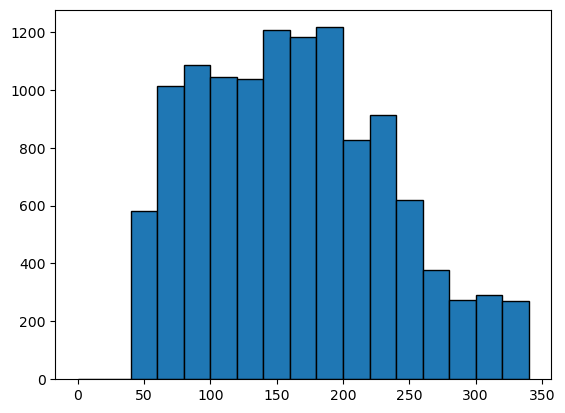

In [11]:
ens.query("band_ztf_source == 'g'", table="source").prune(50)
ens._lazy_sync_tables(table="object")
ens.calc_nobs(temporary=False)

data = ens.compute('object')['nobs_total'].values.astype(int)

bin_edges = range(0, 321 + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')

In [12]:
len(ens._object)


12987

In [13]:
def count_rows(partition):
    return len(partition)

# Let us try the same thing again
n_sources_per_div = ens._source.map_partitions(count_rows, meta=int).compute()

print("Number of rows in each partition:", n_sources_per_div)

/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


Number of rows in each partition: 0    432842
1    191994
2    416199
3    191724
4    409558
5    234907
6    412788
7    204586
dtype: int64


In [14]:
# 18 minutes, 95.17 GB used
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [16]:
len(res_tsp_drw)

12987

# ZTF - Third load

In [8]:
import glob

directory_path = '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/'
file_pattern = 'part.*.parquet'

matching_files = glob.glob(f'{directory_path}{file_pattern}')

for file_path in matching_files:
    print(file_path)

/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.3.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.2.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.1.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.0.parquet


In [9]:
rel_path = "/data3/epyc/data3/hipscat/catalogs/ztf_dr14_x_agns_source"

from pyarrow import parquet
# parquet.read_schema(f"{rel_path}/Norder=8/Dir=210000/Npix=217286.parquet", memory_map=True)

parquet.read_schema(matching_files[0], memory_map=True)

count: double
_hipscat_index: uint64
SDSS_NAME_dr16q_constant: string
PLATE_dr16q_constant: int64
MJD_dr16q_constant: int64
FIBERID_dr16q_constant: int64
RA_dr16q_constant: double
DEC_dr16q_constant: double
OBJID_dr16q_constant: string
IF_BOSS_SDSS_dr16q_constant: string
Z_DR16Q_dr16q_constant: double
SOURCE_Z_DR16Q_dr16q_constant: string
Z_FIT_dr16q_constant: double
Z_SYS_dr16q_constant: double
Z_SYS_ERR_dr16q_constant: double
EBV_dr16q_constant: double
SN_MEDIAN_ALL_dr16q_constant: double
FEII_UV_EW_dr16q_constant: double
FEII_UV_EW_ERR_dr16q_constant: double
FEII_OPT_EW_dr16q_constant: double
FEII_OPT_EW_ERR_dr16q_constant: double
LOGL1350_dr16q_constant: double
LOGL1350_ERR_dr16q_constant: double
LOGL1700_dr16q_constant: double
LOGL1700_ERR_dr16q_constant: double
LOGL2500_dr16q_constant: double
LOGL2500_ERR_dr16q_constant: double
LOGL3000_dr16q_constant: double
LOGL3000_ERR_dr16q_constant: double
LOGL5100_dr16q_constant: double
LOGL5100_ERR_dr16q_constant: double
LOGLBOL_dr16q_cons

In [10]:
test_pd = pd.read_parquet(matching_files[0])

In [11]:
test_pd

,count,_hipscat_index,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,...,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,298.0,7343808069173772288,135628.50+045054.4,856,52339,458,209.118759,4.848461,0856-52339-0458,SDSS,...,0.050652,59274.44767,46,g,6,20000,26090,6,20000,survey_1
1,298.0,7416242961983209472,122749.00+053201.9,2880,54509,581,186.954179,5.533870,2880-54509-0581,SDSS,...,0.079153,58956.25185,39,g,6,20000,26347,6,20000,survey_1
2,298.0,7416242961983209472,122749.00+053201.9,2880,54509,581,186.954179,5.533870,2880-54509-0581,SDSS,...,0.083438,58955.30475,39,g,6,20000,26347,6,20000,survey_1
3,298.0,7416242961983209472,122749.00+053201.9,2880,54509,581,186.954179,5.533870,2880-54509-0581,SDSS,...,0.078276,58955.30152,39,g,6,20000,26347,6,20000,survey_1
4,298.0,7416242961983209472,122749.00+053201.9,2880,54509,581,186.954179,5.533870,2880-54509-0581,SDSS,...,0.069537,58944.25345,39,g,6,20000,26347,6,20000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638022,1012.0,7488300675512664064,131254.92+151528.7,1773,53112,337,198.228874,15.257989,1773-53112-0337,SDSS,...,0.074948,59639.40354,60,g,6,20000,26603,6,20000,survey_1
638023,1012.0,7488300675512664064,131254.92+151528.7,1773,53112,337,198.228874,15.257989,1773-53112-0337,SDSS,...,0.067980,59625.38157,60,g,6,20000,26603,6,20000,survey_1
638024,1012.0,7488300675512664064,131254.92+151528.7,1773,53112,337,198.228874,15.257989,1773-53112-0337,SDSS,...,0.078997,59625.36090,3,g,6,20000,26603,6,20000,survey_1


In [14]:
names = []
for i in range(0,4):
    name = f"/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.{i}.parquet"
    names.append(name)
    
names

['/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.0.parquet',
 '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.1.parquet',
 '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.2.parquet',
 '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.3.parquet']

In [15]:
colmap = ColumnMapper(id_col="count",
                      time_col="mjd_ztf_source",
                      flux_col="mag_ztf_source",
                      err_col="magerr_ztf_source",
                      band_col="band_ztf_source")
ens.from_parquet(source_file=names,
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sorted=True)

In [16]:
ens._source

,_hipscat_index,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,Z_FIT_dr16q_constant,Z_SYS_dr16q_constant,Z_SYS_ERR_dr16q_constant,EBV_dr16q_constant,SN_MEDIAN_ALL_dr16q_constant,FEII_UV_EW_dr16q_constant,FEII_UV_EW_ERR_dr16q_constant,FEII_OPT_EW_dr16q_constant,FEII_OPT_EW_ERR_dr16q_constant,LOGL1350_dr16q_constant,LOGL1350_ERR_dr16q_constant,LOGL1700_dr16q_constant,LOGL1700_ERR_dr16q_constant,LOGL2500_dr16q_constant,LOGL2500_ERR_dr16q_constant,LOGL3000_dr16q_constant,LOGL3000_ERR_dr16q_constant,LOGL5100_dr16q_constant,LOGL5100_ERR_dr16q_constant,LOGLBOL_dr16q_constant,LOGLBOL_ERR_dr16q_constant,LOGMBH_HB_dr16q_constant,LOGMBH_HB_ERR_dr16q_constant,LOGMBH_MGII_dr16q_constant,LOGMBH_MGII_ERR_dr16q_constant,LOGMBH_CIV_dr16q_constant,LOGMBH_CIV_ERR_dr16q_constant,LOGMBH_dr16q_constant,LOGMBH_ERR_dr16q_constant,LOGLEDD_RATIO_dr16q_constant,LOGLEDD_RATIO_ERR_dr16q_constant,Norder_dr16q_constant,Dir_dr16q_constant,Npix_dr16q_constant,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,uint64,string,int64,int64,int64,float64,float64,string,string,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32,category[unknown],category[unknown],string
146.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [19]:
c1 = np.unique(ens._source.get_partition(0).compute()['_hipscat_index'].values, return_counts=True)  
c3 = np.unique(ens._source.get_partition(3).compute()['_hipscat_index'].values, return_counts=True)  

(0.0, 5000.0)

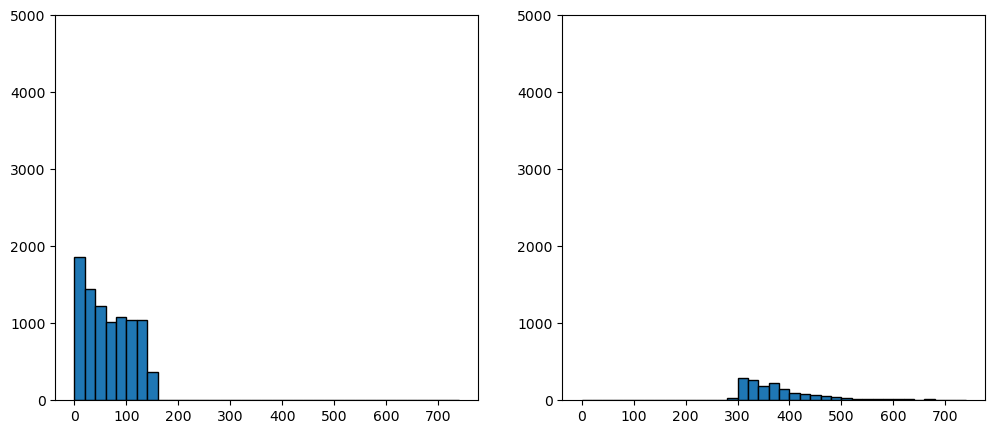

In [20]:
bin_edges = range(0, 721 + 21, 20) 

plt.figure(figsize=(12, 5))

plt.subplot(121 )
plt.hist(c1[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 5000)

plt.subplot(122 )
plt.hist(c3[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 5000)

In [21]:
# 13.5 minutes, 22.84 GB used
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
